In [9]:
#!pip install keras

In [10]:
#!python -m pip install --user --upgrade pip --no-warn-script-location

In [11]:
#!pip install --user --no-warn-script-location tensorflow

In [12]:
#!pip install wordcloud

In [13]:
#!pip install xgboost

In [14]:
#!pip install scikit-multilearn

In [15]:
import pandas as pd 
import  matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
import keras
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score , accuracy_score , confusion_matrix , f1_score,classification_report
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
train_data = pd.read_csv('malignant_train.csv')
print(train_data.shape)
train_data

(159571, 8)


,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [17]:
test_data = pd.read_csv('malignant_test.csv')
print(test_data.shape)
test_data

(153164, 2)


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [18]:
train_data.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

In [19]:
train_data.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
comments = train_data.drop(['id','comment_text'],axis = 1)
for i in comments.columns :
    print("Percent of {0}s: ".format(i), round(100*comments[i].mean(),2), "%")

Percent of malignants:  9.58 %
Percent of highly_malignants:  1.0 %
Percent of rudes:  5.29 %
Percent of threats:  0.3 %
Percent of abuses:  4.94 %
Percent of loathes:  0.88 %


In [21]:
classes = {}
for i in list(comments.columns):
    classes[i] =  comments[i].sum()
n_classes = [classes[i] for i in list(classes.keys())]
classes = list(classes.keys())

<BarContainer object of 6 artists>

<Figure size 864x864 with 0 Axes>

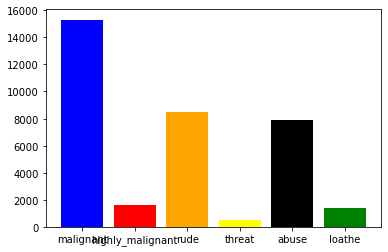

In [22]:
color = ['blue','red','orange','yellow','black','green']
plt.figure(figsize=(12,12))
fig, ax = plt.subplots()
ax.bar(classes,n_classes,color = color)

In [23]:
def  clean_text(text):
    text =  text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)
    
    return text

In [24]:
train_data.comment_text = train_data.comment_text.apply(clean_text)

In [25]:
train_data.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he matches this background colour i am se...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cannot make any real suggestions on im...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [26]:
nltk.download('stopwords')
sn = SnowballStemmer(language='english')


def stemmer(text):
    words =  text.split()
    train = [sn.stem(word) for word in words if not word in set(stopwords.words('english'))]
    return ' '.join(train)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sanjay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
train_data.comment_text = train_data.comment_text.apply(stemmer)

In [29]:
train_data.comment_text.head()

0    explan edit made usernam hardcor metallica fan...
1    daww match background colour seem stuck thank ...
2    hey man realli tri edit war guy constant remov...
3    cannot make real suggest improv wonder section...
4                           sir hero chanc rememb page
Name: comment_text, dtype: object

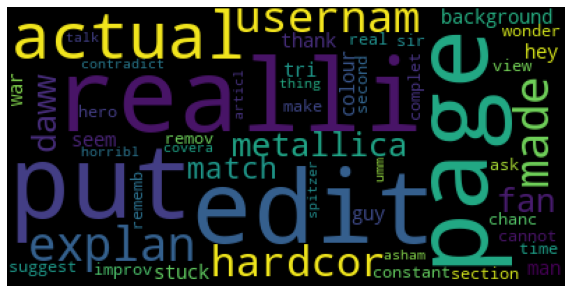

In [30]:
wordcloud = WordCloud(stopwords=stopwords.words('english'),max_words=50).generate(str(train_data.comment_text))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [31]:
x =  train_data.comment_text
y =  train_data.drop(['id','comment_text'],axis = 1)

In [32]:
word_vectorizer = TfidfVectorizer(strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',ngram_range=(1, 3),stop_words='english',sublinear_tf=True) 
x = word_vectorizer.fit_transform(x)

MACHINE LEARNING PROCESS

In [33]:
x_train,x_test,y_train,y_test =  train_test_split(x,y,test_size = 0.2,random_state = 45)

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model=[LogisticRegression(),DecisionTreeClassifier(),MultinomialNB(),RandomForestClassifier()]
for i in model:
    classifier = OneVsRestClassifier(i)
    classifier.fit(x_train,y_train)
    
    pred_test=classifier.predict(x_test)
    
    y_train_pred_proba = classifier.predict_proba(x_train)
    y_test_pred_proba = classifier.predict_proba(x_test)
    
    roc_auc_score_train = roc_auc_score(y_train, y_train_pred_proba,average='weighted')
    roc_auc_score_test = roc_auc_score(y_test, y_test_pred_proba,average='weighted')
    
    print("testing score=",accuracy_score(pred_test,y_test))         
    print("training score=",i.score(x_train,y_train))
    
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)
   
    print(confusion_matrix(pred_test,y_test))
    print(classification_report(pred_test,y_test),"\n")

HYPERPARAMETER TUNING PROCESS FOR THE BEST MODEL

In [35]:
from sklearn.model_selection import GridSearchCV

In [39]:
parameter={"penalty":["l2","none"],
          "fit_intercept":[True,False],
          "solver":["newton-cg","lbfgs","liblinear","sag","saga"],
          "dual":[True,False]}

In [40]:
gcv=GridSearchCV(LogisticRegression(),parameter,cv=5)

In [ ]:
gcv.fit(x_train,y_train)

In [42]:
gcv.best_params_

{'dual': True, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'}

In [46]:
final_model = LogisticRegression(dual=False, penalty='l2', solver = 'newton-cg',fit_intercept=True)
classifier = OneVsRestClassifier(final_model)
classifier.fit(x_train,y_train)
y_train_pred_proba = classifier.predict_proba(x_train)
y_test_pred_proba = classifier.predict_proba(x_test)
roc_auc_score_train = roc_auc_score(y_train, y_train_pred_proba,average='weighted')
roc_auc_score_test = roc_auc_score(y_test, y_test_pred_proba,average='weighted')        
print("ROC AUC Score Train:", roc_auc_score_train)
print("ROC AUC Score Test:", roc_auc_score_test)

ROC AUC Score Train: 0.9944111235625235
ROC AUC Score Test: 0.9735662825612483


TESTING THE MODEL

In [47]:
def make_test_predictions(df,classifier):
    df.comment_text = df.comment_text.apply(clean_text)
    df.comment_text = df.comment_text.apply(stemmer)
    x_test = df.comment_text
    x_test = word_vectorizer.transform(x_test)
    y_test_pred = classifier.predict_proba(x_test)
    return y_test_pred

In [ ]:
make_test_predictions(test_data,classifier)

SAVING THE MODEL

In [49]:
import joblib

joblib.dump(classifier,"malignant_comment_detection.obj")

['malignant_comment_detection.obj']

In [50]:
malignant_comment_detection_from_joblib=joblib.load("malignant_comment_detection.obj")
malignant_comment_detection_from_joblib.predict(x_test)

array([[1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])